First step：prepare data.
1. Join choices dataset with user survey dataset, extract userid whose userid is in both datasets.
2. Limit each user's data records to maxium 26

In [2]:
import pandas as pd
import numpy as np
# load main dataset with certain columns
main = 'SharedResponses.csv'
all_columns = pd.read_csv(main, nrows=0).columns.tolist()
selected_columns = all_columns[:8] + all_columns[14:17] + all_columns[-20:]

# create a new dataframe
df_main = pd.DataFrame()

# load data
for chunk in pd.read_csv(main, usecols=selected_columns, chunksize=1000000, low_memory=False):
    df_main = pd.concat([df_main, chunk], ignore_index=True)
print(df_main.head())

          ResponseID              ExtendedSessionID        UserID  \
0  2222bRQqBTZ6dLnPH    32757157_6999801415950060.0  6.999801e+15   
1  2222sJk4DcoqXXi98        1043988516_3525281295.0  3.525281e+09   
2  2223CNmvTr2Coj4wp  -1613944085_422160228641876.0  4.221602e+14   
3  2223Xu54ufgjcyMR3   1425316635_327833569077076.0  3.278336e+14   
4  2223jMWDEGNeszivb  -1683127088_785070916172117.0  7.850709e+14   

   ScenarioOrder  Intervention  PedPed  Barrier  CrossingSignal  \
0              7             0       0        0               1   
1              2             0       0        0               0   
2             10             0       1        0               1   
3             11             0       0        1               0   
4              8             0       1        0               2   

   NumberOfCharacters  DiffNumberOFCharacters  ...  LargeMan Criminal  \
0                 5.0                     0.0  ...       0.0      0.0   
1                 1.0               

In [7]:
df_main.to_csv('main_feature_1.csv')

In [14]:
file_path = 'SharedResponsesSurvey.csv'

# extract 'UserID' that has only one unique gender from survey dataset

columns_to_load = ['UserID', 'Review_gender']
df = pd.read_csv(file_path, usecols=columns_to_load)
df = df[df['Review_gender'].isin(['male', 'female'])]

unique_counts = df.groupby('UserID')['Review_gender'].nunique()

user_ids_with_single_gender = unique_counts[unique_counts == 1].index

df_filtered = df[df['UserID'].isin(user_ids_with_single_gender)]

df_unique = df_filtered.drop_duplicates()

In [4]:
merged_chunks = []

chunksize = 100000
f1_path = 'main_feature_1.csv'
# merge 32 columns' main data with user data through 'UserID'
for chunk in pd.read_csv(f1_path, chunksize=chunksize):
    merged_chunk = pd.merge(df_unique, chunk, on='UserID', how='inner')
    merged_chunks.append(merged_chunk)

final_merged_df = pd.concat(merged_chunks, ignore_index=True)

print(final_merged_df.shape)

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/290439338.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/290439338.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/290439338.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/290439338.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(f1_path, chunksize=chunksize):
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000

(12498056, 34)


Strategy of filtering data:

Step 1: Group by UserID and calculate the total data volume and unique ResponseID number for each user. If total=26 and unique=13, keep all data of these users.
Step 2: If total<26, filter out all rows where ResponseID appears twice and the Saved column is 0 and 1 respectively, and keep this part of the data.
Step 3: If total>26, randomly select 13 ResponseIDs, and these ResponseIDs appear twice and the Saved column is 0 and 1 respectively.

In [5]:
import pandas as pd
import numpy as np

# group by UserID and calculate total rows per user
grouped_df = final_merged_df.groupby('UserID').agg(
    total_rows=('UserID', 'size'),  
    unique_responseids=('ResponseID', 'nunique')  
).reset_index()

# Step 1: keep data that total = 26 & unique = 13 
condition_1 = grouped_df[(grouped_df['total_rows'] == 26) & (grouped_df['unique_responseids'] == 13)]
filtered_df_1 = final_merged_df[final_merged_df['UserID'].isin(condition_1['UserID'])]

# Step 2: for users whose total < 26，make sure responseid is paired
condition_2 = grouped_df[grouped_df['total_rows'] < 26]

# total < 26
filtered_df_2 = final_merged_df[final_merged_df['UserID'].isin(condition_2['UserID'])]

# filter ResponseID = 2 & Saved contains 0 and 1
def filter_responseid_group(group):
    valid_responses = group.groupby('ResponseID').filter(lambda x: (len(x) == 2) and (x['Saved'].nunique() == 2))
    return valid_responses

filtered_df_2 = filtered_df_2.groupby('UserID').apply(filter_responseid_group).reset_index(drop=True)

# Step 3: for users whose total > 26 的用户，pick 13 valid ResponseID randomaly
condition_3 = grouped_df[grouped_df['total_rows'] > 26]

# total > 26
filtered_df_3 = final_merged_df[final_merged_df['UserID'].isin(condition_3['UserID'])]

def random_sample(group):
    valid_responses = group.groupby('ResponseID').filter(lambda x: (len(x) == 2) and (x['Saved'].nunique() == 2))
    
    if len(valid_responses['ResponseID'].unique()) > 13:
        selected_responseids = np.random.choice(valid_responses['ResponseID'].unique(), size=13, replace=False)
        
        sample_responses = valid_responses[valid_responses['ResponseID'].isin(selected_responseids)]
        return sample_responses
    else:
        return valid_responses

filtered_df_3 = filtered_df_3.groupby('UserID').apply(random_sample).reset_index(drop=True)

# concat
final_filtered_df = pd.concat([filtered_df_1, filtered_df_2, filtered_df_3], ignore_index=True)

print(final_filtered_df)

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1354483035.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_2 = filtered_df_2.groupby('UserID').apply(filter_responseid_group).reset_index(drop=True)
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1354483035.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df_3 = filtered_df_3.groupby('UserID').appl

         Unnamed: 0_x        UserID Review_gender  Unnamed: 0_y  \
0               35887  7.981091e+15        female         94911   
1               39421  5.209783e+15          male         35711   
2               46548  7.888200e+14          male         43929   
3               61949  3.988589e+15          male         74460   
4               91769  1.757899e+15          male         83556   
...               ...           ...           ...           ...   
9415961       1165967  9.999993e+15          male      58736098   
9415962       1165967  9.999993e+15          male      59294721   
9415963       1165967  9.999993e+15          male      62445802   
9415964       1165967  9.999993e+15          male      67260929   
9415965       1165967  9.999993e+15          male      67817653   

                ResponseID               ExtendedSessionID  ScenarioOrder  \
0        2A8SAxAa6dLGK4bGm  -2119938054_7981090920342526.0             11   
1        254hWwD8y4bcCtxp8  -2117293878_5

In [9]:
final_filtered_df.to_csv('1123_final_join_1.csv')

Second Step - Feaure Engineering: Decompose and reorganize people's characteristics

First feature engineering

In [16]:
df = final_filtered_df

# convert float columns to int
float_cols = df.select_dtypes(include=['float64']).columns.tolist()
df[float_cols] = df[float_cols].astype(int)
df['Man'] = df['Man'].astype(float).round(0).astype(int)

# tranform to new features
df['Male'] = df['Man'] + df['OldMan'] + df['Boy'] + df['MaleExecutive'] + df['MaleAthlete'] + df['MaleDoctor'] + df['LargeMan']
df['Female'] = df['Woman'] + df['OldWoman'] + df['Girl'] + df['FemaleExecutive'] + df['FemaleAthlete'] + df['FemaleDoctor'] + df['LargeWoman']
df['Pregnant'] = df['Pregnant']  
df['Baby'] = df['Stroller']  
df['Children'] = df['Boy'] + df['Girl']  
df['Adult'] = df['Man'] + df['Woman'] + df['MaleExecutive'] + df['FemaleExecutive'] + df['FemaleAthlete'] + df['MaleAthlete'] + df['FemaleDoctor'] + df['MaleDoctor'] + df['LargeWoman'] + df['LargeMan']  
df['Senior'] = df['OldMan'] + df['OldWoman']  
df['Large'] = df['LargeMan'] + df['LargeWoman']  
df['Profession'] = df['MaleExecutive'] + df['FemaleExecutive'] + df['FemaleAthlete'] + df['MaleAthlete'] + df['FemaleDoctor'] + df['MaleDoctor']  
df['Criminal'] = df['Criminal']  
df['Homeless'] = df['Homeless']  
df['Animal'] = df['Dog'] + df['Cat']  

print(df[['Male', 'Female', 'Pregnant', 'Baby', 'Children', 'Adult', 'Senior', 'Large', 'Profession', 'Criminal', 'Homeless', 'Animal']])

         Male  Female  Pregnant  Baby  Children  Adult  Senior  Large  \
0           1       2         0     0         2      0       1      0   
1           1       0         0     0         0      1       0      0   
2           0       0         1     0         0      0       0      0   
3           3       0         0     0         0      3       0      0   
4           1       2         0     0         0      3       0      0   
...       ...     ...       ...   ...       ...    ...     ...    ...   
9415961     0       1         0     0         1      0       0      0   
9415962     1       0         0     0         0      1       0      0   
9415963     2       0         0     0         0      2       0      1   
9415964     0       4         0     0         0      3       1      1   
9415965     0       1         0     0         0      1       0      0   

         Profession  Criminal  Homeless  Animal  
0                 0         0         0       0  
1                 0    

In [18]:
# delete original characteristics columns (oldman, oldwoman...)
new_role_features = [
    'Male', 'Female', 'Pregnant', 'Baby', 'Children', 'Adult', 
    'Senior', 'Large', 'Profession', 'Criminal', 'Homeless', 'Animal'
]

original_columns = [
    'UserID', 'Review_gender', 'ResponseID', 'ExtendedSessionID', 'ScenarioOrder', 
    'Intervention', 'PedPed', 'Barrier', 'CrossingSignal', 
    'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved'
]

# concat new and old
final_columns = original_columns + new_role_features

new_df = df[final_columns]

print(new_df.head())

             UserID Review_gender         ResponseID  \
0  7981090920342530        female  2A8SAxAa6dLGK4bGm   
1  5209782729596510          male  254hWwD8y4bcCtxp8   
2   788820015732199          male  25mYXXQZzcAg2sG5E   
3  3988588530966880          male  28NEGFNWWDt5kwi4g   
4  1757898902303930          male  29AfQqsgNAiGCRwpc   

                ExtendedSessionID  ScenarioOrder  Intervention  PedPed  \
0  -2119938054_7981090920342526.0             11             0       1   
1  -2117293878_5209782729596508.0              6             0       0   
2   -2112010153_788820015732199.0              6             0       0   
3  -2100276797_3988588530966876.0             13             0       0   
4  -2077599832_1757898902303930.0              2             0       0   

   Barrier  CrossingSignal  NumberOfCharacters  ...  Pregnant  Baby  Children  \
0        0               2                   3  ...         0     0         2   
1        1               0                   1  ...     

In [19]:
# calculate ratio of features
new_role_features = [
    'Male', 'Female', 'Pregnant', 'Baby', 'Children', 'Adult', 
    'Senior', 'Large', 'Profession', 'Criminal', 'Homeless', 'Animal'
]

for feature in new_role_features:
    proportion_column = feature + '_Ratio' 
    new_df[proportion_column] = new_df[feature] / new_df['NumberOfCharacters']

print(new_df.head())

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[proportion_column] = new_df[feature] / new_df['NumberOfCharacters']
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[proportion_column] = new_df[feature] / new_df['NumberOfCharacters']
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A 

             UserID Review_gender         ResponseID  \
0  7981090920342530        female  2A8SAxAa6dLGK4bGm   
1  5209782729596510          male  254hWwD8y4bcCtxp8   
2   788820015732199          male  25mYXXQZzcAg2sG5E   
3  3988588530966880          male  28NEGFNWWDt5kwi4g   
4  1757898902303930          male  29AfQqsgNAiGCRwpc   

                ExtendedSessionID  ScenarioOrder  Intervention  PedPed  \
0  -2119938054_7981090920342526.0             11             0       1   
1  -2117293878_5209782729596508.0              6             0       0   
2   -2112010153_788820015732199.0              6             0       0   
3  -2100276797_3988588530966876.0             13             0       0   
4  -2077599832_1757898902303930.0              2             0       0   

   Barrier  CrossingSignal  NumberOfCharacters  ...  Pregnant_Ratio  \
0        0               2                   3  ...             0.0   
1        1               0                   1  ...             0.0   
2    

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[proportion_column] = new_df[feature] / new_df['NumberOfCharacters']
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[proportion_column] = new_df[feature] / new_df['NumberOfCharacters']
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/1807757143.py:9: SettingWithCopyWarning: 
A 

In [20]:
# calculate diff of ratio between two groups in one scenaio (group by responseID)
ratio_features = [
    'Male_Ratio', 'Female_Ratio', 'Pregnant_Ratio', 'Baby_Ratio', 
    'Children_Ratio', 'Adult_Ratio', 'Senior_Ratio', 'Large_Ratio', 
    'Profession_Ratio', 'Criminal_Ratio', 'Homeless_Ratio', 'Animal_Ratio'
]

# sort by responseid, saved to calculate diff among groups
new_df = new_df.sort_values(by=['ResponseID', 'Saved']).reset_index(drop=True)

result_df = new_df.copy()

for feature in ratio_features:
    diff_col = feature + '_diff'
    
    result_df[diff_col] = new_df[feature] - new_df[feature].shift(-1)

for feature in ratio_features:
    diff_col = feature + '_diff'
    result_df[diff_col] = result_df[diff_col].where(result_df['Saved'] == 1, -result_df[diff_col])

# delete value in odd line
for feature in ratio_features:
    diff_col = feature + '_diff'
    result_df.loc[result_df['Saved'] == 1, diff_col] = None

# input odd line's value as opposite value of even line
for feature in ratio_features:
    diff_col = feature + '_diff'
    result_df[diff_col] = result_df[diff_col].fillna(method='bfill') * -1

# set（Saved=1）'s line's number as last line's opposite value
for feature in ratio_features:
    diff_col = feature + '_diff'
    
    result_df.loc[result_df['Saved'] == 1, diff_col] = -result_df[diff_col].shift(1)

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_5672/2809183651.py:30: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  result_df[diff_col] = result_df[diff_col].fillna(method='bfill') * -1


In [22]:
result_df.to_csv('1123_1st_feature_engineering.csv')

First modelling on first feature engineering
Train XGBoost model on first feature engineering's dataset.
First we implement stepwise_feature_selection to select top features that could influence model performance. Then form a group of most important feaures to train XGBoost model

In [60]:
result_df = pd.read_csv('1123_1st_feature_engineering.csv')

Starting Ratio Feature Selection


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Male_Ratio' - AUC: 0.5851


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Female_Ratio' - AUC: 0.6327


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Pregnant_Ratio' - AUC: 0.6350


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Baby_Ratio' - AUC: 0.6377


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Children_Ratio' - AUC: 0.6657


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Adult_Ratio' - AUC: 0.6886


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Senior_Ratio' - AUC: 0.6886


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Large_Ratio' - AUC: 0.6970


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Profession_Ratio' - AUC: 0.7027


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Criminal_Ratio' - AUC: 0.7029


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Homeless_Ratio' - AUC: 0.7049


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Ratio Feature - Adding feature 'Animal_Ratio' - AUC: 0.7053

Final Ratio Feature Feature Ranking by AUC improvement:
Animal_Ratio: 0.7053
Homeless_Ratio: 0.7049
Criminal_Ratio: 0.7029
Profession_Ratio: 0.7027
Large_Ratio: 0.6970
Senior_Ratio: 0.6886
Adult_Ratio: 0.6886
Children_Ratio: 0.6657
Baby_Ratio: 0.6377
Pregnant_Ratio: 0.6350
Female_Ratio: 0.6327
Male_Ratio: 0.5851

Starting Diff Feature Selection


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Male_Ratio_diff' - AUC: 0.6038


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Female_Ratio_diff' - AUC: 0.6754


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Pregnant_Ratio_diff' - AUC: 0.6850


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Baby_Ratio_diff' - AUC: 0.6918


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Children_Ratio_diff' - AUC: 0.7389


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Adult_Ratio_diff' - AUC: 0.7469


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Senior_Ratio_diff' - AUC: 0.7487


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Large_Ratio_diff' - AUC: 0.7547


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Profession_Ratio_diff' - AUC: 0.7556


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Criminal_Ratio_diff' - AUC: 0.7560


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Homeless_Ratio_diff' - AUC: 0.7573


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Diff Feature - Adding feature 'Animal_Ratio_diff' - AUC: 0.7587

Final Diff Feature Feature Ranking by AUC improvement:
Animal_Ratio_diff: 0.7587
Homeless_Ratio_diff: 0.7573
Criminal_Ratio_diff: 0.7560
Profession_Ratio_diff: 0.7556
Large_Ratio_diff: 0.7547
Senior_Ratio_diff: 0.7487
Adult_Ratio_diff: 0.7469
Children_Ratio_diff: 0.7389
Baby_Ratio_diff: 0.6918
Pregnant_Ratio_diff: 0.6850
Female_Ratio_diff: 0.6754
Male_Ratio_diff: 0.6038

Starting Environment Feature Selection


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Environment Feature - Adding feature 'Intervention' - AUC: 0.5423


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Environment Feature - Adding feature 'Barrier' - AUC: 0.5501


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Environment Feature - Adding feature 'CrossingSignal' - AUC: 0.6343

Final Environment Feature Feature Ranking by AUC improvement:
CrossingSignal: 0.6343
Barrier: 0.5501
Intervention: 0.5423

Final Selected Features: ['Male_Ratio', 'Female_Ratio', 'Pregnant_Ratio', 'Baby_Ratio', 'Children_Ratio', 'Adult_Ratio', 'Senior_Ratio', 'Large_Ratio', 'Profession_Ratio', 'Criminal_Ratio', 'Homeless_Ratio', 'Animal_Ratio', 'Male_Ratio_diff', 'Female_Ratio_diff', 'Pregnant_Ratio_diff', 'Baby_Ratio_diff', 'Children_Ratio_diff', 'Adult_Ratio_diff', 'Senior_Ratio_diff', 'Large_Ratio_diff', 'Profession_Ratio_diff', 'Criminal_Ratio_diff', 'Homeless_Ratio_diff', 'Animal_Ratio_diff', 'Intervention', 'Barrier', 'CrossingSignal']


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-logloss:0.64359
[1]	validation_0-logloss:0.61460
[2]	validation_0-logloss:0.59866
[3]	validation_0-logloss:0.58479
[4]	validation_0-logloss:0.57674
[5]	validation_0-logloss:0.56975
[6]	validation_0-logloss:0.56565
[7]	validation_0-logloss:0.56230
[8]	validation_0-logloss:0.55872
[9]	validation_0-logloss:0.55496
[10]	validation_0-logloss:0.55300
[11]	validation_0-logloss:0.55172
[12]	validation_0-logloss:0.55069
[13]	validation_0-logloss:0.54970
[14]	validation_0-logloss:0.54880
[15]	validation_0-logloss:0.54773
[16]	validation_0-logloss:0.54654
[17]	validation_0-logloss:0.54581
[18]	validation_0-logloss:0.54518
[19]	validation_0-logloss:0.54478
[20]	validation_0-logloss:0.54445
[21]	validation_0-logloss:0.54410
[22]	validation_0-logloss:0.54371
[23]	validation_0-logloss:0.54337
[24]	validation_0-logloss:0.54307
[25]	validation_0-logloss:0.54274
[26]	validation_0-logloss:0.54257
[27]	validation_0-logloss:0.54198
[28]	validation_0-logloss:0.54160
[29]	validation_0-loglos

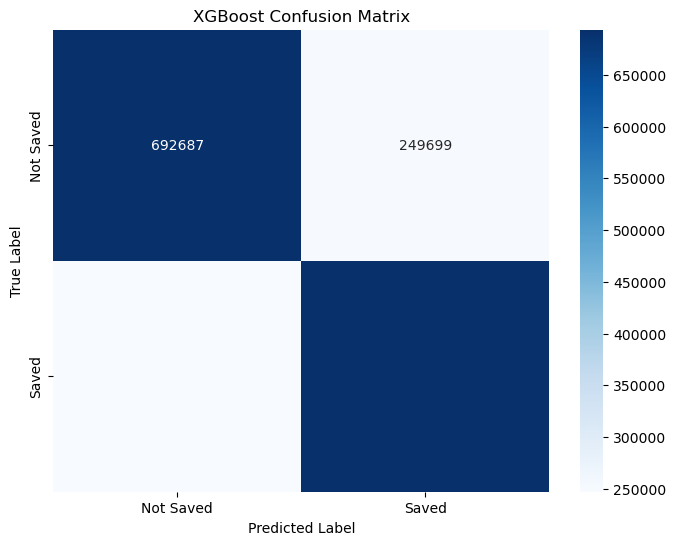

In [61]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# split feaures into 3 groups: ratio, diff, environment
target = 'Saved'
ratio_features = [
    'Male_Ratio', 'Female_Ratio', 'Pregnant_Ratio', 'Baby_Ratio', 
    'Children_Ratio', 'Adult_Ratio', 'Senior_Ratio', 'Large_Ratio', 
    'Profession_Ratio', 'Criminal_Ratio', 'Homeless_Ratio', 'Animal_Ratio'
]
diff_features = [f + '_diff' for f in ratio_features]
env_features = ['Intervention', 'Barrier', 'CrossingSignal']

# set features and target
X = result_df[ratio_features + diff_features + env_features]
y = result_df[target]

# split dataset into train/val/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# choose features by step-size
def stepwise_feature_selection(X_train, X_valid, y_train, y_valid, feature_list, feature_type):
    selected_features = []
    feature_importance = {}
    best_auc = 0
    
    for feature in feature_list:
        current_features = selected_features + [feature]
        
        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        model.fit(
            X_train[current_features], y_train,
            eval_set=[(X_valid[current_features], y_valid)],
            early_stopping_rounds=10,  
            verbose=False
        )
        
        y_pred = model.predict_proba(X_valid[current_features])[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        
        feature_importance[feature] = auc
        print(f"{feature_type} - Adding feature '{feature}' - AUC: {auc:.4f}")
        
        # if current feature could improve model performance, then add to the final features; else discard
        if auc > best_auc:
            best_auc = auc
            selected_features.append(feature)

    # sort features by AUC
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    print(f"\nFinal {feature_type} Feature Ranking by AUC improvement:")
    for feature, score in sorted_features:
        print(f"{feature}: {score:.4f}")
    
    return selected_features

# 1. perform feature selection on each group of features
print("Starting Ratio Feature Selection")
best_ratio_features = stepwise_feature_selection(X_train, X_valid, y_train, y_valid, ratio_features, "Ratio Feature")

print("\nStarting Diff Feature Selection")
best_diff_features = stepwise_feature_selection(X_train, X_valid, y_train, y_valid, diff_features, "Diff Feature")

print("\nStarting Environment Feature Selection")
best_env_features = stepwise_feature_selection(X_train, X_valid, y_train, y_valid, env_features, "Environment Feature")

# 2. merge the best features for final model training and validation
final_features = best_ratio_features + best_diff_features + best_env_features
print("\nFinal Selected Features:", final_features)

# build final model
final_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
final_model.fit(
    X_train[final_features], y_train,
    eval_set=[(X_valid[final_features], y_valid)],
    early_stopping_rounds=10,
    verbose=True
)

# predict & evaluate
y_final_pred = final_model.predict_proba(X_test[final_features])[:, 1]
final_auc = roc_auc_score(y_test, y_final_pred)
print(f"\nFinal Model AUC with Combined Features: {final_auc:.4f}")

# calculate evaluation metrcs
y_final_pred_class = final_model.predict(X_test[final_features])
accuracy = accuracy_score(y_test, y_final_pred_class)
recall = recall_score(y_test, y_final_pred_class)
precision = precision_score(y_test, y_final_pred_class)
f1 = f1_score(y_test, y_final_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_final_pred_class)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

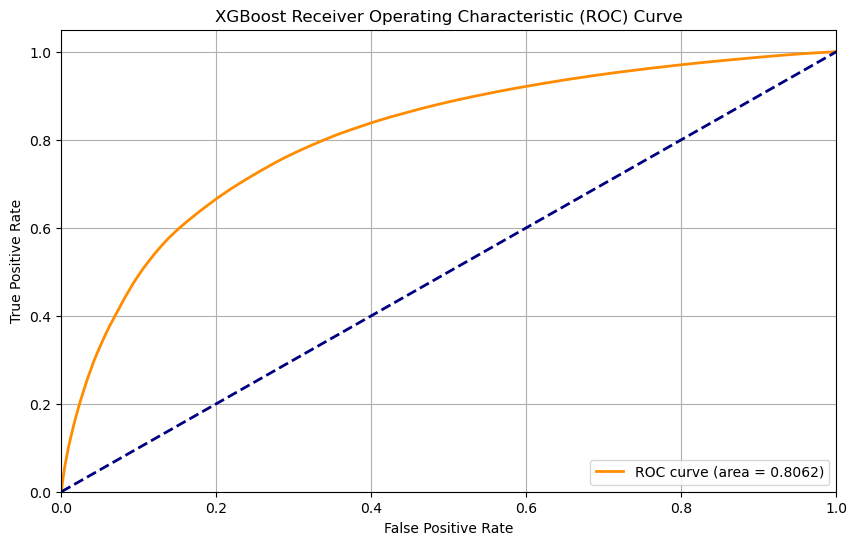

In [63]:
from sklearn.metrics import roc_curve, auc

# Generate ROC Curve values
fpr, tpr, _ = roc_curve(y_test, y_final_pred)
roc_auc = auc(fpr, tpr)

# Plotting the ROC Curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Second Feature Engineering
Create number-judging features. Compare within responseID to get more/less/equal features based on 1st feature engineering

In [2]:
import pandas as pd
d = pd.read_csv('1123_1st_feature_engineering.csv')
d.shape

(9415966, 49)

In [4]:
df = pd.read_csv('1123_1st_feature_engineering.csv')

selected_columns = ['UserID', 'ResponseID', 'ExtendedSessionID', 'ScenarioOrder', 'Intervention', 'PedPed',
                    'Barrier', 'CrossingSignal', 'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved', 
                    'Male', 'Female', 'Pregnant', 'Baby', 'Children', 'Adult', 'Senior', 'Large', 
                    'Profession', 'Criminal', 'Homeless', 'Animal']

df_selected = df[selected_columns]

df_grouped = df_selected.copy()

# group by 'ResponseID'，compare within the group, more would be set as 1, less would be set as -1, equal set as 0 
grouped = df_grouped.groupby('ResponseID')
def compare_feature(group, feature_name):
    result = [0] * len(group)
    
    if len(group) == 2:
        # Compare the feature values between the two rows
        if group.iloc[0][feature_name] > group.iloc[1][feature_name]:
            result[0], result[1] = 1, -1
        elif group.iloc[0][feature_name] < group.iloc[1][feature_name]:
            result[0], result[1] = -1, 1
    
    # Return the result as a pandas Series with the correct index
    return pd.Series(result, index=group.index)

# Apply the functions to calculate each new feature and store them in the dataframe

# 1. Cross by rule
df_grouped['if_cross_by_rule'] = df_grouped['CrossingSignal'].apply(lambda x: -1 if x == 2 else x)

# 2. Compare NumberOfCharacters
df_grouped['if_more_people'] = grouped.apply(lambda x: compare_feature(x, 'NumberOfCharacters')).reset_index(level=0, drop=True)

# 3. Compare Male (based on Male proportion over Male + Female)
def compare_male_proportion(group):
    result = [0] * len(group)
    if len(group) == 2:
        male_female_ratio_0 = group.iloc[0]['Male'] / (group.iloc[0]['Male'] + group.iloc[0]['Female'] + 1e-6)  # Avoid division by zero
        male_female_ratio_1 = group.iloc[1]['Male'] / (group.iloc[1]['Male'] + group.iloc[1]['Female'] + 1e-6)
        if male_female_ratio_0 > male_female_ratio_1:
            result[0], result[1] = 1, -1
        elif male_female_ratio_0 < male_female_ratio_1:
            result[0], result[1] = -1, 1
    return pd.Series(result, index=group.index)

df_grouped['if_more_male'] = grouped.apply(lambda x: compare_male_proportion(x)).reset_index(level=0, drop=True)

# 4. Compare Vulnerable (Pregnant + Baby)
df_grouped['if_more_vulnerable'] = grouped.apply(lambda x: compare_feature(x, 'Pregnant') + compare_feature(x, 'Baby')).reset_index(level=0, drop=True)

# 5. Compare Children
df_grouped['if_more_children'] = grouped.apply(lambda x: compare_feature(x, 'Children')).reset_index(level=0, drop=True)

# 6. Compare Senior
df_grouped['if_more_senior'] = grouped.apply(lambda x: compare_feature(x, 'Senior')).reset_index(level=0, drop=True)

# 7. Compare Criminal
df_grouped['if_more_criminal'] = grouped.apply(lambda x: compare_feature(x, 'Criminal')).reset_index(level=0, drop=True)

# 8. Compare Homeless
df_grouped['if_more_homeless'] = grouped.apply(lambda x: compare_feature(x, 'Homeless')).reset_index(level=0, drop=True)

# 9. Compare Profession
df_grouped['if_more_profession'] = grouped.apply(lambda x: compare_feature(x, 'Profession')).reset_index(level=0, drop=True)

# 10. Compare Large (indicating large-sized individuals)
df_grouped['if_more_large'] = grouped.apply(lambda x: compare_feature(x, 'Large')).reset_index(level=0, drop=True)

# 11. Compare Animal
df_grouped['if_more_animal'] = grouped.apply(lambda x: compare_feature(x, 'Animal')).reset_index(level=0, drop=True)

/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_6704/1944221468.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped['if_more_people'] = grouped.apply(lambda x: compare_feature(x, 'NumberOfCharacters')).reset_index(level=0, drop=True)
/var/folders/x5/b6qvk1zx3dg9d_8_8zt4hf3m0000gn/T/ipykernel_6704/1944221468.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped['if_more_male'

In [5]:
df_grouped.shape

(9415966, 34)

In [6]:
df_grouped.columns

Index(['UserID', 'ResponseID', 'ExtendedSessionID', 'ScenarioOrder',
       'Intervention', 'PedPed', 'Barrier', 'CrossingSignal',
       'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved', 'Male',
       'Female', 'Pregnant', 'Baby', 'Children', 'Adult', 'Senior', 'Large',
       'Profession', 'Criminal', 'Homeless', 'Animal', 'if_cross_by_rule',
       'if_more_people', 'if_more_male', 'if_more_vulnerable',
       'if_more_children', 'if_more_senior', 'if_more_criminal',
       'if_more_homeless', 'if_more_profession', 'if_more_large',
       'if_more_animal'],
      dtype='object')

In [7]:
df_grouped.to_csv('1123_2nd_feature_engineering_without_gender.csv')

Train RankNet model on 2nd feature engineering's dataset

Calculate feature importance through Randomforest

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
df=df_grouped
X = df[['Intervention', 'Barrier', 'if_cross_by_rule',
        'if_more_people', 'if_more_male', 'if_more_vulnerable',
        'if_more_children', 'if_more_senior', 'if_more_criminal',
        'if_more_homeless', 'if_more_profession', 'if_more_large',
        'if_more_animal']]
y = df['Saved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random forest model training
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# obtain feture importance
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance based on RandomForest:")
print(feature_importance_df)


# Permutation Importance for feature importance verification
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

print("\nFeature Importance based on Permutation Importance:")
print(perm_importance_df)

Feature Importance based on RandomForest:
               Feature  Importance
6     if_more_children    0.192981
2     if_cross_by_rule    0.182867
3       if_more_people    0.145727
10  if_more_profession    0.133423
12      if_more_animal    0.090998
5   if_more_vulnerable    0.058405
7       if_more_senior    0.048538
4         if_more_male    0.041853
0         Intervention    0.025547
11       if_more_large    0.025434
1              Barrier    0.023811
9     if_more_homeless    0.017368
8     if_more_criminal    0.013049

Feature Importance based on Permutation Importance:
               Feature  Permutation Importance
3       if_more_people                0.064800
2     if_cross_by_rule                0.049104
12      if_more_animal                0.048067
6     if_more_children                0.034274
10  if_more_profession                0.023621
7       if_more_senior                0.018021
11       if_more_large                0.015037
4         if_more_male                0

Borda Count Method：
Assign scores to features according to their rankings, then accumulate the ranking scores of different models, and finally sort by the accumulated scores.


Combined Feature Importance Based on Rank (Borda Count Method):
               Feature  Combined Rank Score
2     if_cross_by_rule                  4.0
3       if_more_people                  4.0
6     if_more_children                  5.0
12      if_more_animal                  8.0
10  if_more_profession                  9.0
7       if_more_senior                 13.0
5   if_more_vulnerable                 15.0
4         if_more_male                 16.0
11       if_more_large                 17.0
0         Intervention                 20.0
9     if_more_homeless                 22.0
1              Barrier                 24.0
8     if_more_criminal                 25.0


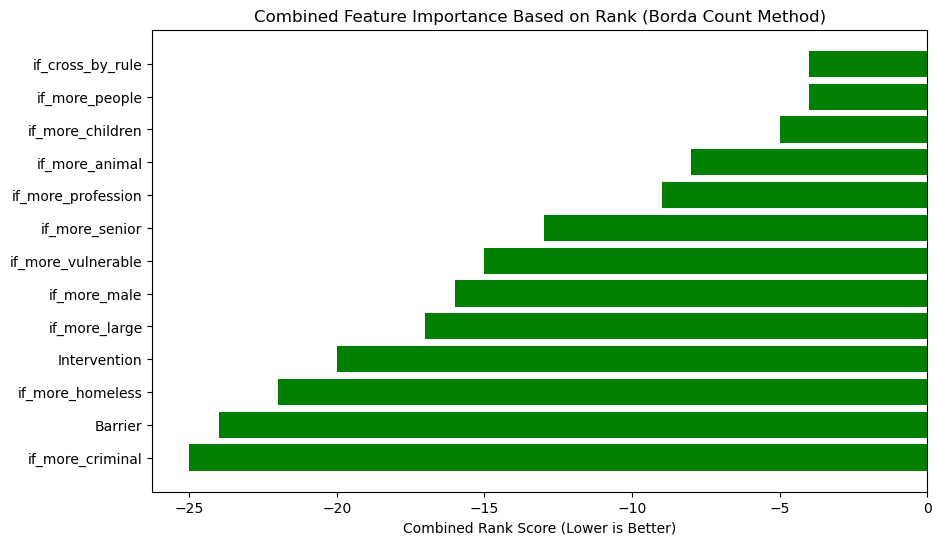

In [11]:

feature_importance_df['Rank_RF'] = feature_importance_df['Importance'].rank(ascending=False)
perm_importance_df['Rank_Perm'] = perm_importance_df['Permutation Importance'].rank(ascending=False)

# overall grade by Borda Count 
feature_importance_df['Combined Rank Score'] = feature_importance_df['Rank_RF'] + perm_importance_df['Rank_Perm']

# rank by overall grade
combined_rank_df = feature_importance_df[['Feature', 'Combined Rank Score']].sort_values(by='Combined Rank Score')

print("\nCombined Feature Importance Based on Rank (Borda Count Method):")
print(combined_rank_df)

# plot
plt.figure(figsize=(10, 6))
plt.barh(combined_rank_df['Feature'], -combined_rank_df['Combined Rank Score'], color='g')
plt.xlabel('Combined Rank Score (Lower is Better)')
plt.title('Combined Feature Importance Based on Rank (Borda Count Method)')
plt.gca().invert_yaxis()
plt.show()


Spilt train/test/val while making sure same ResponseID's two rows are placed into same datasets

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

important_features = ['if_cross_by_rule', 'if_more_people', 'if_more_children', 'if_more_animal', 'if_more_profession', 
                'if_more_senior', 'if_more_vulnerable', 'if_more_male', 'if_more_large', 
                'Intervention', 'if_more_homeless', 'Barrier', 'if_more_criminal']

X = df[important_features]
y = df['Saved']
response_ids = df['ResponseID']

# A faster splitting method uses GroupShuffleSplit to ensure that samples with the same ResponseID are assigned to the same dataset
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=response_ids))

train_val_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# split val&test
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(gss_val.split(train_val_df[important_features], train_val_df['Saved'], groups=train_val_df['ResponseID']))

train_df = train_val_df.iloc[train_idx]
val_df = train_val_df.iloc[val_idx]

X_train = train_df[important_features]
y_train = train_df['Saved']
X_val = val_df[important_features]
y_val = val_df['Saved']
X_test = test_df[important_features]
y_test = test_df['Saved']

In [72]:
import pandas as pd
import numpy as np

# create a dictionary for feature & corresponding grade
combined_rank_df = pd.DataFrame({
    'Feature': ['if_cross_by_rule', 'if_more_people', 'if_more_children', 'if_more_animal', 'if_more_profession', 
                'if_more_senior', 'if_more_vulnerable', 'if_more_male', 'if_more_large', 
                'Intervention', 'if_more_homeless', 'Barrier', 'if_more_criminal'],
    'Combined Rank Score': [4.0, 4.0, 5.0, 8.0, 9.0, 13.0, 15.0, 16.0, 17.0, 20.0, 22.0, 24.0, 25.0]
})

# calculate: 1 / rank_score
combined_rank_df['Weight'] = 1 / combined_rank_df['Combined Rank Score']

# nrmoalization
combined_rank_df['Normalized Weight'] = combined_rank_df['Weight'] / combined_rank_df['Weight'].sum()

# nrmoalization * 100
combined_rank_df['Scaled Weight'] = combined_rank_df['Normalized Weight'] * 10

print(combined_rank_df[['Feature', 'Scaled Weight']])

scaled_importances = combined_rank_df.set_index('Feature').loc[important_features]['Scaled Weight'].values

print("\nWeights Array (scaled_importances):")
print(scaled_importances)


               Feature  Scaled Weight
0     if_cross_by_rule       1.814032
1       if_more_people       1.814032
2     if_more_children       1.451225
3       if_more_animal       0.907016
4   if_more_profession       0.806236
5       if_more_senior       0.558164
6   if_more_vulnerable       0.483742
7         if_more_male       0.453508
8        if_more_large       0.426831
9         Intervention       0.362806
10    if_more_homeless       0.329824
11             Barrier       0.302339
12    if_more_criminal       0.290245

Weights Array (scaled_importances):
[1.81403185 1.81403185 1.45122548 0.90701592 0.80623638 0.55816364
 0.48374183 0.45350796 0.42683102 0.36280637 0.32982397 0.30233864
 0.2902451 ]


Epoch 1/50, Loss: 0.5483042702765076
Validation Loss: 0.5393307715204987
Epoch 2/50, Loss: 0.5470472830831385
Validation Loss: 0.5390948939669896
Epoch 3/50, Loss: 0.5470336521676095
Validation Loss: 0.5387575905817741
Epoch 4/50, Loss: 0.5470954951045407
Validation Loss: 0.5388195692130862
Epoch 5/50, Loss: 0.5469739241275774
Validation Loss: 0.5409465744504046
Epoch 6/50, Loss: 0.5471600695597363
Validation Loss: 0.5384983960515697
Epoch 7/50, Loss: 0.5470234024074807
Validation Loss: 0.5395623889293201
Epoch 8/50, Loss: 0.5470830739213153
Validation Loss: 0.5387560284300836
Epoch 9/50, Loss: 0.547006301942942
Validation Loss: 0.5386572047591615
Epoch 10/50, Loss: 0.5470326259444676
Validation Loss: 0.5390922474959344
Epoch 11/50, Loss: 0.5470258425649003
Validation Loss: 0.5393520510638582
Early stopping triggered.
                ResponseID  Predicted Probability  Lower CI  Upper CI  \
538439   222Bih22xMQR5brhF               0.858531  0.858530  0.858532   
538438   222Bih22xMQR5br

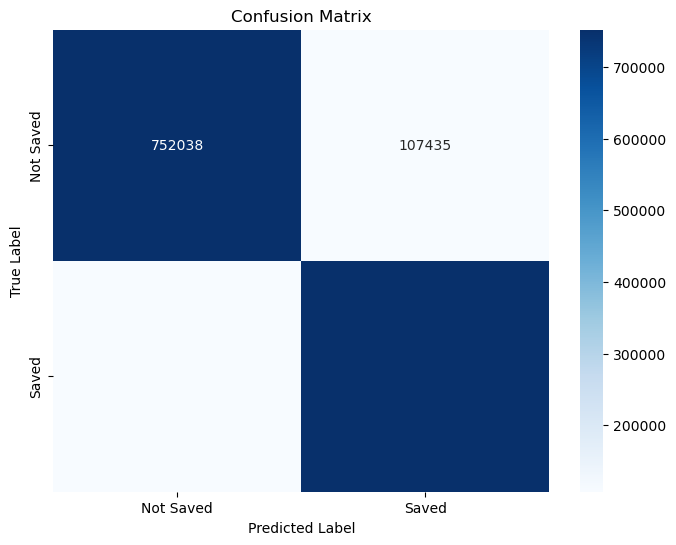

In [40]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import norm
import seaborn as sns

# build RankNet
class RankNetDataset(Dataset):
    def __init__(self, df, features, feature_importances):
        self.features = df[features].values
        self.labels = df['Saved'].values
        self.response_ids = df['ResponseID'].values
        self.feature_importances = feature_importances

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Weight the feature values ​​and use the scaled feature importance
        features = self.features[idx] * self.feature_importances
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        response_id = self.response_ids[idx]
        return features, labels, response_id

# construct a dataset and data loader with scaled feature importances
train_dataset = RankNetDataset(train_df, important_features, scaled_importances)
val_dataset = RankNetDataset(val_df, important_features, scaled_importances)
test_dataset = RankNetDataset(test_df, important_features, scaled_importances)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x

input_dim = len(important_features)
model = RankNet(input_dim)

# BCEWithLogitsLoss as loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train RankNet with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, _ in train_loader:
        features = features.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(features)  
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, _ in val_loader:
            features = features.float()
            labels = labels.float().view(-1, 1)
            outputs = model(features)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_ranknet_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_ranknet_model.pth'))

# predict and calculate confidence interval
num_bootstrap_samples = 100  # Bootstrap 
model.eval()
all_predictions = []

with torch.no_grad():
    for _ in range(num_bootstrap_samples):
        bootstrap_predictions = []
        for features, labels, response_ids in test_loader:
            features = features.float()
            outputs = torch.sigmoid(model(features)).view(-1)  # predict by sigmoid output probability
            bootstrap_predictions.extend(outputs.numpy())
        all_predictions.append(bootstrap_predictions)

all_predictions = np.array(all_predictions)  
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)

z_score = norm.ppf(0.975)  # 95% interval
lower_bounds = mean_predictions - z_score * std_predictions
upper_bounds = mean_predictions + z_score * std_predictions

predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float()
        outputs = torch.sigmoid(model(features)).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(mean_predictions[i])
            lower_bound = float(lower_bounds[i])
            upper_bound = float(upper_bounds[i])
            predictions.append((response_ids[i], mean_pred, lower_bound, upper_bound, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Probability', 'Lower CI', 'Upper CI', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Probability', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Probability'])

print(f"\nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Try another RankNet: Lambda RankNet

Epoch 1/50, Loss: 0.43967431062736484
Validation Loss: 0.43567117736455746
Epoch 2/50, Loss: 0.43780369427216126
Validation Loss: 0.4354935545484173
Epoch 3/50, Loss: 0.43794927091462693
Validation Loss: 0.43603611579320467
Epoch 4/50, Loss: 0.43770390008277094
Validation Loss: 0.43534252316442057
Epoch 5/50, Loss: 0.43778417546652415
Validation Loss: 0.4351107431726058
Epoch 6/50, Loss: 0.43763822235718053
Validation Loss: 0.435634267345704
Epoch 7/50, Loss: 0.4376205321275333
Validation Loss: 0.4351639758334151
Epoch 8/50, Loss: 0.4378415667340621
Validation Loss: 0.4354225316428592
Epoch 9/50, Loss: 0.4376713934153822
Validation Loss: 0.4352610102782849
Epoch 10/50, Loss: 0.43760703115991284
Validation Loss: 0.43538323066171286
Early stopping triggered.
                ResponseID  Predicted Score  True Label  Predicted Saved
538439   222Bih22xMQR5brhF         1.686209         1.0                1
538438   222Bih22xMQR5brhF        -1.999445         0.0                0
244501   222fX

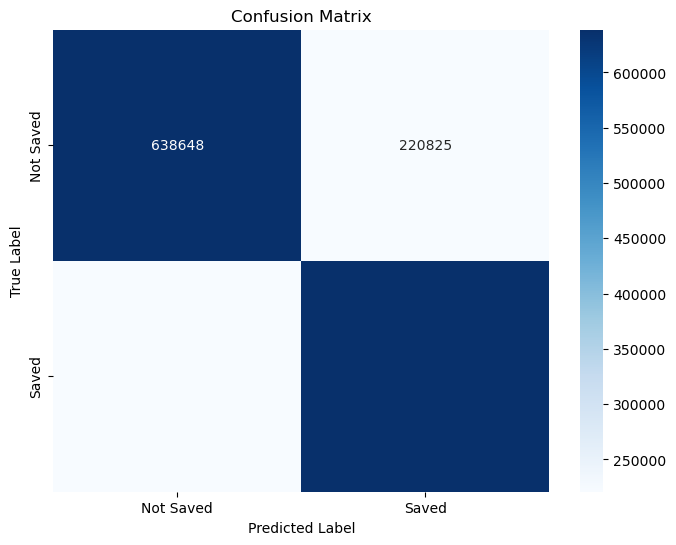

In [76]:
# build LambdaRankNet
class LambdaRankNetDataset(Dataset):
    def __init__(self, df, features, feature_importances):
        self.features = df[features].values
        self.labels = df['Saved'].values
        self.response_ids = df['ResponseID'].values
        self.feature_importances = feature_importances

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Weight the feature values ​​and use the scaled feature importance
        features = self.features[idx] * self.feature_importances
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        response_id = self.response_ids[idx]
        return features, labels, response_id

# construct a dataset and data loader with scaled feature importances
train_dataset = LambdaRankNetDataset(train_df, important_features, scaled_importances)
val_dataset = LambdaRankNetDataset(val_df, important_features, scaled_importances)
test_dataset = LambdaRankNetDataset(test_df, important_features, scaled_importances)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class LambdaRankNet(nn.Module):
    def __init__(self, input_dim):
        super(LambdaRankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = len(important_features)
model = LambdaRankNet(input_dim)

# Loss function using LambdaRank approach
def lambda_loss(outputs, labels):
    pairwise_diff = outputs.unsqueeze(1) - outputs.unsqueeze(0)
    pairwise_labels = labels.unsqueeze(1) - labels.unsqueeze(0)
    s_ij = pairwise_labels.sign()
    sigma = 1.0
    loss_matrix = -torch.log(torch.sigmoid(sigma * s_ij * pairwise_diff) + 1e-10)
    loss = loss_matrix[pairwise_labels != 0].mean()
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train LambdaRankNet with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, response_ids in train_loader:
        features = features.float().to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(features).view(-1)  # get predicted scores
        
        # Compute pairwise lambda loss
        batch_loss = lambda_loss(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, response_ids in val_loader:
            features = features.float().to(device)
            labels = labels.float().to(device)
            outputs = model(features).view(-1)  
            batch_loss = lambda_loss(outputs, labels)
            val_loss += batch_loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lambdaranknet_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_lambdaranknet_model.pth'))
model.to(device)

# predict
model.eval()
predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float().to(device)
        outputs = model(features).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(outputs[i])
            predictions.append((response_ids[i], mean_pred, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Score', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Score', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Score'])

print(f"\nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Epoch 1/50, Loss: 0.203939130017891
Validation Loss: 0.20174394808165455
Epoch 2/50, Loss: 0.2024863829319665
Validation Loss: 0.20189099381648415
Epoch 3/50, Loss: 0.20250259122116454
Validation Loss: 0.20168120975840145
Epoch 4/50, Loss: 0.2025026488982335
Validation Loss: 0.2012046170054913
Epoch 5/50, Loss: 0.20261810285230344
Validation Loss: 0.2018002612783706
Epoch 6/50, Loss: 0.2023560062268946
Validation Loss: 0.2015677379086
Epoch 7/50, Loss: 0.20253336713561665
Validation Loss: 0.20144762890974927
Epoch 8/50, Loss: 0.20251505872716205
Validation Loss: 0.20168653253323301
Epoch 9/50, Loss: 0.20248073686783338
Validation Loss: 0.20135996663588046
Early stopping triggered.
                ResponseID  Predicted Score  True Label  Predicted Saved
538439   222Bih22xMQR5brhF        15.490289         1.0                1
538438   222Bih22xMQR5brhF       -35.454327         0.0                0
244501   222fXTmjrmjJx8k4r         8.498401         1.0                1
244500   222fXTmjr

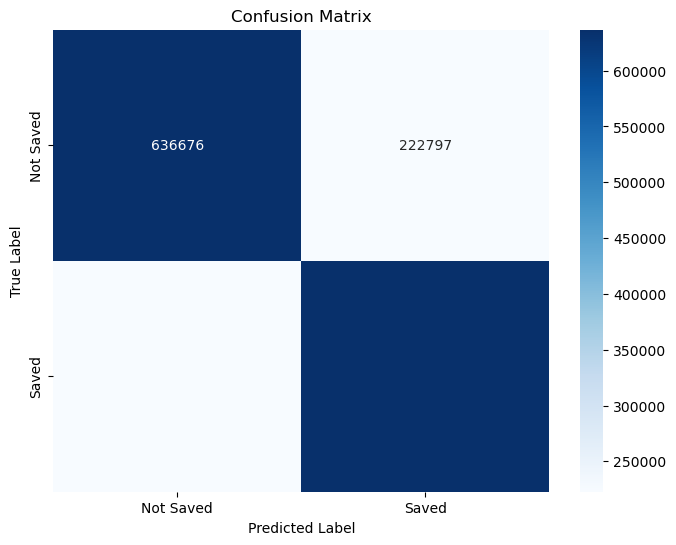

In [78]:
# Lambda Mart
class LambdaMART(nn.Module):
    def __init__(self, input_dim):
        super(LambdaMART, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_dim = len(important_features)
model = LambdaMART(input_dim)

# Loss function using LambdaMART approach
def lambda_mart_loss(outputs, labels):
    pairwise_diff = outputs.unsqueeze(1) - outputs.unsqueeze(0)
    pairwise_labels = labels.unsqueeze(1) - labels.unsqueeze(0)
    s_ij = pairwise_labels.sign()
    sigma = 1.0
    lambda_matrix = torch.sigmoid(-sigma * s_ij * pairwise_diff)
    gain = (2 ** labels.unsqueeze(1) - 1) - (2 ** labels.unsqueeze(0) - 1)
    loss_matrix = lambda_matrix * gain.abs()
    loss = loss_matrix[pairwise_labels != 0].mean()
    return loss

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train LambdaMART with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, response_ids in train_loader:
        features = features.float().to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(features).view(-1)  # get predicted scores
        
        # Compute pairwise lambda mart loss
        batch_loss = lambda_mart_loss(outputs, labels)
        batch_loss.backward()
        optimizer.step()

        running_loss += batch_loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, response_ids in val_loader:
            features = features.float().to(device)
            labels = labels.float().to(device)
            outputs = model(features).view(-1)  
            batch_loss = lambda_mart_loss(outputs, labels)
            val_loss += batch_loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_lambdamart_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_lambdamart_model.pth'))
model.to(device)

# predict
model.eval()
predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float().to(device)
        outputs = model(features).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(outputs[i])
            predictions.append((response_ids[i], mean_pred, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Score', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Score', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Score'])

print(f"\nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Step Four - Analyze model bias by gender


Correct/Incorrect Counts by Gender:
 Predicted Accurate   False    True 
Review_gender                      
female               60274   421848
male                154596  1082228

Correct/Incorrect Ratios by Gender:
 Predicted Accurate     False     True 
Review_gender                         
female              0.125018  0.874982
male                0.124994  0.875006


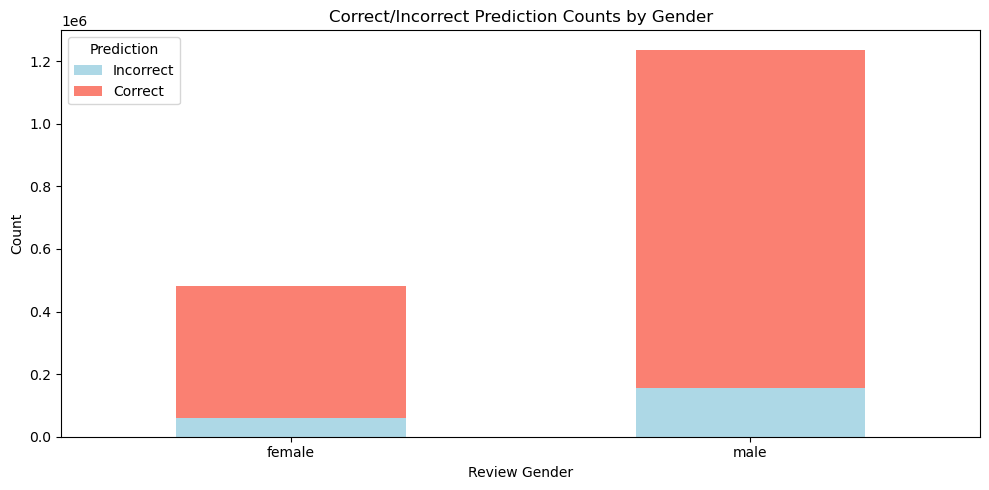

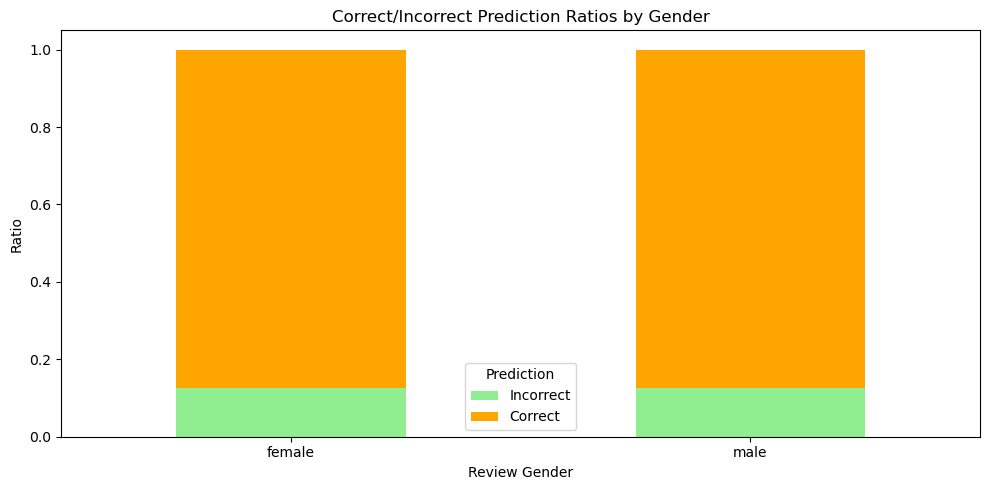

In [42]:
# analyse test_df by gender
test_df2=test_df[['ResponseID','UserID','Review_gender']]
test_df2 = test_df2.drop_duplicates(subset=['ResponseID', 'UserID', 'Review_gender'])

# add users' gender information into final prediction's data
final_predictions_df2=final_predictions_df.merge(test_df2[['ResponseID', 'UserID','Review_gender']], on='ResponseID', how='left')
final_predictions_df2['Predicted Accurate'] = final_predictions_df2['True Label']==final_predictions_df2['Predicted Saved']

grouped_accuracy = final_predictions_df2.groupby('Review_gender')['Predicted Accurate'].value_counts(normalize=False).unstack(fill_value=0)
grouped_accuracy_ratio = final_predictions_df2.groupby('Review_gender')['Predicted Accurate'].value_counts(normalize=True).unstack(fill_value=0)

print("\nCorrect/Incorrect Counts by Gender:\n", grouped_accuracy)
print("\nCorrect/Incorrect Ratios by Gender:\n", grouped_accuracy_ratio)

# Plot Correct/Incorrect Counts by Gender
plt.figure(figsize=(10, 5))
grouped_accuracy.plot(kind='bar', stacked=True, color=['lightblue', 'salmon'], ax=plt.gca())
plt.xlabel('Review Gender')
plt.ylabel('Count')
plt.title('Correct/Incorrect Prediction Counts by Gender')
plt.xticks(rotation=0)
plt.legend(['Incorrect', 'Correct'], title='Prediction')
plt.tight_layout()
plt.show()

# Plot Correct/Incorrect Ratios by Gender
plt.figure(figsize=(10, 5))
grouped_accuracy_ratio.plot(kind='bar', stacked=True, color=['lightgreen', 'orange'], ax=plt.gca())
plt.xlabel('Review Gender')
plt.ylabel('Ratio')
plt.title('Correct/Incorrect Prediction Ratios by Gender')
plt.xticks(rotation=0)
plt.legend(['Incorrect', 'Correct'], title='Prediction')
plt.tight_layout()
plt.show()


In [43]:
# t-test to check if there's bias among male and female group
from scipy.stats import norm, ttest_ind
final_predictions_df2['diff'] = abs(final_predictions_df2['Predicted Probability']-final_predictions_df2['True Label'])
diff_male = final_predictions_df2[final_predictions_df2['Review_gender'] == 'male']['diff']
diff_female = final_predictions_df2[final_predictions_df2['Review_gender'] == 'female']['diff']

t_stat, p_value = ttest_ind(diff_male, diff_female, equal_var=False)
print(f"\nT-test for gender difference in 'diff':\nT-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
if p_value < 0.05:
    print("There is a statistically significant difference between male and female diff values.")
else:
    print("There is no statistically significant difference between male and female diff values.")

male_predictions_df = final_predictions_df2[final_predictions_df2['Review_gender']=='male']
female_predictions_df = final_predictions_df2[final_predictions_df2['Review_gender']=='female']


T-test for gender difference in 'diff':
T-statistic: -0.9360, P-value: 0.3493
There is no statistically significant difference between male and female diff values.


In [47]:
# select top10 wrongly predicted group features by gender
final_predictions_join_all = test_df.merge(final_predictions_df2[['ResponseID', 'True Label','Predicted Probability', 'Predicted Accurate', 'diff']], on='ResponseID', how='inner')
final_predictions_join_all = final_predictions_join_all[final_predictions_join_all['Saved'] == final_predictions_join_all['True Label']]

male_wrong_case = final_predictions_join_all[(final_predictions_join_all['Review_gender'] == 'male') & (final_predictions_join_all['Predicted Accurate'] == False)]
female_wrong_case = final_predictions_join_all[(final_predictions_join_all['Review_gender'] == 'female') & (final_predictions_join_all['Predicted Accurate'] == False)]

important_features = ['if_more_people', 'if_cross_by_rule', 'if_more_children',
                      'if_more_animal', 'if_more_profession', 'if_more_vulnerable',
                      'if_more_senior', 'if_more_male', 'if_more_large',
                      'Intervention', 'if_more_homeless', 'Barrier', 'if_more_criminal','Saved']

# male's
male_wrong_selected = male_wrong_case[important_features]
top_10_combinations = male_wrong_selected.groupby(important_features).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
print('Male top 10 wrongly saved predictions: \n',top_10_combinations)

# female's
female_wrong_selected = female_wrong_case[important_features]
top_10_combinations_w = female_wrong_selected.groupby(important_features).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
print('Female top 10 wrongly saved predictions: \n',top_10_combinations_w)

Male top 10 wrongly saved predictions: 
        if_more_people  if_cross_by_rule  if_more_children  if_more_animal  \
10457               0                 0                 0               0   
10397               0                 0                 0               0   
8763                0                 0                -1               0   
12062               0                 0                 1               0   
12066               0                 0                 1               0   
7856                0                -1                 0               0   
10236               0                 0                 0               0   
10388               0                 0                 0               0   
7819                0                -1                 0               0   
8767                0                 0                -1               0   

       if_more_profession  if_more_vulnerable  if_more_senior  if_more_male  \
10457                   0       

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


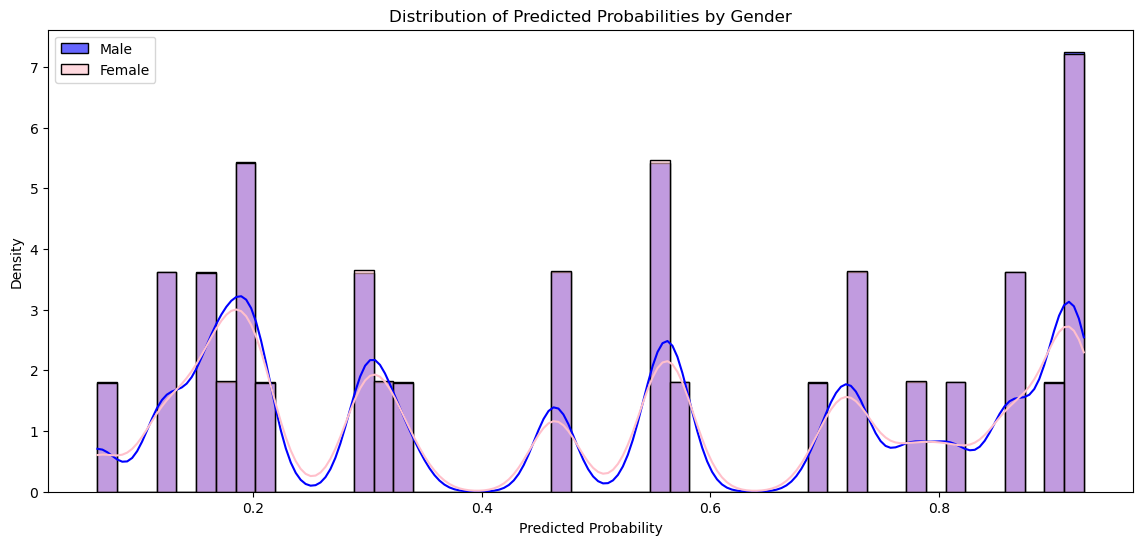

KL Divergence (Male || Female): 0.0000
KL Divergence (Female || Male): 0.0000
Average KL Divergence between Male and Female: 0.0000


In [48]:
# calculate KL divergence
from scipy.stats import entropy

male_predictions = final_predictions_df2[final_predictions_df2['Review_gender'] == 'male']['Predicted Probability']
female_predictions = final_predictions_df2[final_predictions_df2['Review_gender'] == 'female']['Predicted Probability']

# saved probability histogram
plt.figure(figsize=(14, 6))
sns.histplot(male_predictions, color='blue', label='Male', kde=True, stat='density', bins=50, alpha=0.6)
sns.histplot(female_predictions, color='pink', label='Female', kde=True, stat='density', bins=50, alpha=0.6)
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Gender')
plt.legend()
plt.show()

male_hist, male_bins = np.histogram(male_predictions, bins=50, range=(0, 1), density=True)
female_hist, female_bins = np.histogram(female_predictions, bins=50, range=(0, 1), density=True)

male_hist = male_hist + 1e-10  
female_hist = female_hist + 1e-10

# KL divergence
kl_divergence_male_to_female = entropy(male_hist, female_hist)
kl_divergence_female_to_male = entropy(female_hist, male_hist)

print(f"KL Divergence (Male || Female): {kl_divergence_male_to_female:.4f}")
print(f"KL Divergence (Female || Male): {kl_divergence_female_to_male:.4f}")

# mean of KL divergence
average_kl_divergence = (kl_divergence_male_to_female + kl_divergence_female_to_male) / 2
print(f"Average KL Divergence between Male and Female: {average_kl_divergence:.4f}")


Find feaure importante and model performance on Male and Female respectively

In [65]:
df_male = df[df['Review_gender']=='male']
df_female = df[df['Review_gender']=='female']

Feature Importance based on RandomForest:
               Feature  Importance
2     if_cross_by_rule    0.180480
6     if_more_children    0.180400
10  if_more_profession    0.148064
3       if_more_people    0.134416
12      if_more_animal    0.098630
5   if_more_vulnerable    0.058314
7       if_more_senior    0.046146
4         if_more_male    0.039579
0         Intervention    0.029269
11       if_more_large    0.027776
1              Barrier    0.024817
9     if_more_homeless    0.017934
8     if_more_criminal    0.014174

Feature Importance based on Permutation Importance:
               Feature  Permutation Importance
3       if_more_people                0.063692
12      if_more_animal                0.051854
2     if_cross_by_rule                0.051501
6     if_more_children                0.033251
10  if_more_profession                0.023769
7       if_more_senior                0.020183
4         if_more_male                0.018116
11       if_more_large                0

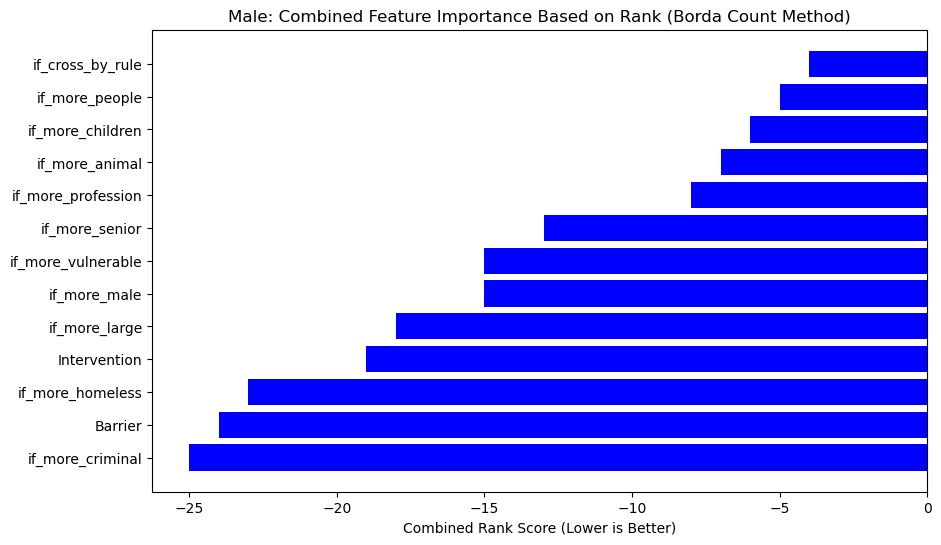

In [66]:
# Male's feature importance (saving choice preference)
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def feature_importance(df):
        X = df[['Intervention', 'Barrier', 'if_cross_by_rule',
                'if_more_people', 'if_more_male', 'if_more_vulnerable',
                'if_more_children', 'if_more_senior', 'if_more_criminal',
                'if_more_homeless', 'if_more_profession', 'if_more_large',
                'if_more_animal']]
        y = df['Saved']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random forest model training
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # obtain feture importance
        feature_importances = rf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("Feature Importance based on RandomForest:")
        print(feature_importance_df)


        # Permutation Importance for feature importance verification
        perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
        perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

        print("\nFeature Importance based on Permutation Importance:")
        print(perm_importance_df)

        feature_importance_df['Rank_RF'] = feature_importance_df['Importance'].rank(ascending=False)
        perm_importance_df['Rank_Perm'] = perm_importance_df['Permutation Importance'].rank(ascending=False)

        # overall grade by Borda Count Method
        feature_importance_df['Combined Rank Score'] = feature_importance_df['Rank_RF'] + perm_importance_df['Rank_Perm']

        # rank by overall grade
        combined_rank_df = feature_importance_df[['Feature', 'Combined Rank Score']].sort_values(by='Combined Rank Score')

        print("\nCombined Feature Importance Based on Rank (Borda Count Method):")
        print(combined_rank_df)

        # plot
        plt.figure(figsize=(10, 6))
        plt.barh(combined_rank_df['Feature'], -combined_rank_df['Combined Rank Score'], color='b')
        plt.xlabel('Combined Rank Score (Lower is Better)')
        plt.title('Male: Combined Feature Importance Based on Rank (Borda Count Method)')
        plt.gca().invert_yaxis()
        plt.show()
feature_importance(df_male)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

df = df_male
important_features = ['if_cross_by_rule', 'if_more_people', 'if_more_children', 'if_more_animal', 'if_more_profession', 
                'if_more_senior', 'if_more_vulnerable', 'if_more_male', 'if_more_large', 
                'Intervention', 'if_more_homeless', 'Barrier', 'if_more_criminal']

X = df[important_features]
y = df['Saved']
response_ids = df['ResponseID']

# A faster splitting method uses GroupShuffleSplit to ensure that samples with the same ResponseID are assigned to the same dataset
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=response_ids))

train_val_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# split val&test
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(gss_val.split(train_val_df[important_features], train_val_df['Saved'], groups=train_val_df['ResponseID']))

train_df = train_val_df.iloc[train_idx]
val_df = train_val_df.iloc[val_idx]

X_train = train_df[important_features]
y_train = train_df['Saved']
X_val = val_df[important_features]
y_val = val_df['Saved']
X_test = test_df[important_features]
y_test = test_df['Saved']

In [53]:
import pandas as pd
import numpy as np

# create a dictionary for feature & corresponding grade
combined_rank_df = pd.DataFrame({
    'Feature': ['if_cross_by_rule', 'if_more_people', 'if_more_children', 'if_more_animal', 'if_more_profession', 
                'if_more_senior', 'if_more_vulnerable', 'if_more_male', 'if_more_large', 
                'Intervention', 'if_more_homeless', 'Barrier', 'if_more_criminal'],
    'Combined Rank Score': [4.0, 5.0, 6.0, 7.0, 8.0, 13.0, 15.0, 15.0, 18.0, 19.0, 23.0, 24.0, 25.0]
})

# calculate: 1 / rank_score
combined_rank_df['Weight'] = 1 / combined_rank_df['Combined Rank Score']

# nrmoalization
combined_rank_df['Normalized Weight'] = combined_rank_df['Weight'] / combined_rank_df['Weight'].sum()

# nrmoalization * 100
combined_rank_df['Scaled Weight'] = combined_rank_df['Normalized Weight'] * 10

print(combined_rank_df[['Feature', 'Scaled Weight']])

scaled_importances = combined_rank_df.set_index('Feature').loc[important_features]['Scaled Weight'].values

print("\nWeights Array (scaled_importances):")
print(scaled_importances)


               Feature  Scaled Weight
0     if_cross_by_rule       1.882371
1       if_more_people       1.505897
2     if_more_children       1.254914
3       if_more_animal       1.075641
4   if_more_profession       0.941185
5       if_more_senior       0.579191
6   if_more_vulnerable       0.501966
7         if_more_male       0.501966
8        if_more_large       0.418305
9         Intervention       0.396289
10    if_more_homeless       0.327369
11             Barrier       0.313728
12    if_more_criminal       0.301179

Weights Array (scaled_importances):
[1.88237097 1.50589677 1.25491398 1.07564055 0.94118548 0.57919107
 0.50196559 0.50196559 0.41830466 0.39628862 0.32736886 0.31372849
 0.30117935]


Epoch 1/50, Loss: 0.5431338404379652
Validation Loss: 0.5336529544981053
Epoch 2/50, Loss: 0.541555448284529
Validation Loss: 0.5330207052224443
Epoch 3/50, Loss: 0.5413660266816095
Validation Loss: 0.5342317619956936
Epoch 4/50, Loss: 0.541345386187968
Validation Loss: 0.5335686692388123
Epoch 5/50, Loss: 0.5412209764478187
Validation Loss: 0.5351473539191643
Epoch 6/50, Loss: 0.5411443281780915
Validation Loss: 0.5333640058407281
Epoch 7/50, Loss: 0.5412019591352883
Validation Loss: 0.5331762205197819
Early stopping triggered.
               ResponseID  Predicted Probability  Lower CI  Upper CI  \
767133  222FT9fvbKwBrHNyN               0.404219  0.404219  0.404220   
767132  222FT9fvbKwBrHNyN               0.343113  0.343113  0.343113   
559195  222cT7cNHuupkipSw               0.734176  0.734175  0.734177   
559194  222cT7cNHuupkipSw               0.112348  0.112348  0.112348   
861652  222g6fjY7f2F9rQzv               0.521427  0.521426  0.521428   
...                   ...        

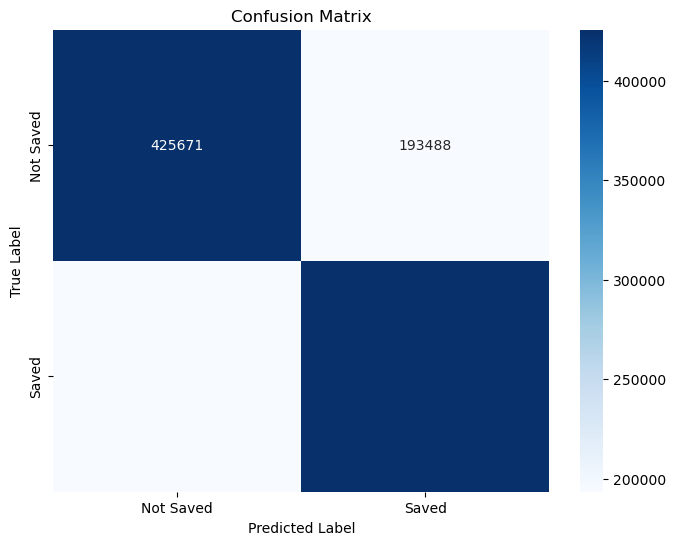

In [54]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import norm
import seaborn as sns

# build RankNet
class RankNetDataset(Dataset):
    def __init__(self, df, features, feature_importances):
        self.features = df[features].values
        self.labels = df['Saved'].values
        self.response_ids = df['ResponseID'].values
        self.feature_importances = feature_importances

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Weight the feature values ​​and use the scaled feature importance
        features = self.features[idx] * self.feature_importances
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        response_id = self.response_ids[idx]
        return features, labels, response_id

# construct a dataset and data loader with scaled feature importances
train_dataset = RankNetDataset(train_df, important_features, scaled_importances)
val_dataset = RankNetDataset(val_df, important_features, scaled_importances)
test_dataset = RankNetDataset(test_df, important_features, scaled_importances)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x

input_dim = len(important_features)
model = RankNet(input_dim)

# BCEWithLogitsLoss as loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train RankNet with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, _ in train_loader:
        features = features.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(features)  
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, _ in val_loader:
            features = features.float()
            labels = labels.float().view(-1, 1)
            outputs = model(features)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_ranknet_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_ranknet_model.pth'))

# predict and calculate confidence interval
num_bootstrap_samples = 100  # Bootstrap 
model.eval()
all_predictions = []

with torch.no_grad():
    for _ in range(num_bootstrap_samples):
        bootstrap_predictions = []
        for features, labels, response_ids in test_loader:
            features = features.float()
            outputs = torch.sigmoid(model(features)).view(-1)  # predict by sigmoid output probability
            bootstrap_predictions.extend(outputs.numpy())
        all_predictions.append(bootstrap_predictions)

all_predictions = np.array(all_predictions)  
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)

z_score = norm.ppf(0.975)  # 95% interval
lower_bounds = mean_predictions - z_score * std_predictions
upper_bounds = mean_predictions + z_score * std_predictions

predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float()
        outputs = torch.sigmoid(model(features)).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(mean_predictions[i])
            lower_bound = float(lower_bounds[i])
            upper_bound = float(upper_bounds[i])
            predictions.append((response_ids[i], mean_pred, lower_bound, upper_bound, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Probability', 'Lower CI', 'Upper CI', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Probability', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Probability'])

print(f"\n Male: \nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nMale Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Feature Importance based on RandomForest:
               Feature  Importance
6     if_more_children    0.198197
3       if_more_people    0.177235
2     if_cross_by_rule    0.169560
10  if_more_profession    0.099035
12      if_more_animal    0.067351
5   if_more_vulnerable    0.064226
4         if_more_male    0.058463
7       if_more_senior    0.053125
11       if_more_large    0.028563
9     if_more_homeless    0.024005
1              Barrier    0.021958
0         Intervention    0.019557
8     if_more_criminal    0.018726

Feature Importance based on Permutation Importance:
               Feature  Permutation Importance
3       if_more_people                0.062942
2     if_cross_by_rule                0.047930
6     if_more_children                0.043270
12      if_more_animal                0.039749
4         if_more_male                0.032607
10  if_more_profession                0.024560
7       if_more_senior                0.018454
5   if_more_vulnerable                0

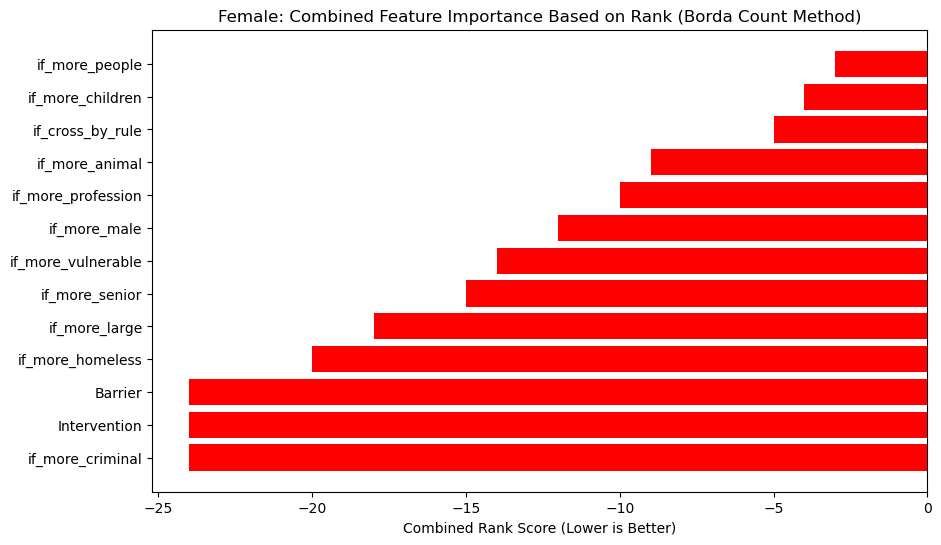

In [68]:
# female
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def feature_importance(df):
        X = df[['Intervention', 'Barrier', 'if_cross_by_rule',
                'if_more_people', 'if_more_male', 'if_more_vulnerable',
                'if_more_children', 'if_more_senior', 'if_more_criminal',
                'if_more_homeless', 'if_more_profession', 'if_more_large',
                'if_more_animal']]
        y = df['Saved']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random forest model training
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # obtain feture importance
        feature_importances = rf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("Feature Importance based on RandomForest:")
        print(feature_importance_df)


        # Permutation Importance for feature importance verification
        perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
        perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

        print("\nFeature Importance based on Permutation Importance:")
        print(perm_importance_df)

        feature_importance_df['Rank_RF'] = feature_importance_df['Importance'].rank(ascending=False)
        perm_importance_df['Rank_Perm'] = perm_importance_df['Permutation Importance'].rank(ascending=False)

        # overall grade by Borda Count Method
        feature_importance_df['Combined Rank Score'] = feature_importance_df['Rank_RF'] + perm_importance_df['Rank_Perm']

        # rank by overall grade
        combined_rank_df = feature_importance_df[['Feature', 'Combined Rank Score']].sort_values(by='Combined Rank Score')

        print("\nCombined Feature Importance Based on Rank (Borda Count Method):")
        print(combined_rank_df)

        # plot
        plt.figure(figsize=(10, 6))
        plt.barh(combined_rank_df['Feature'], -combined_rank_df['Combined Rank Score'], color='r')
        plt.xlabel('Combined Rank Score (Lower is Better)')
        plt.title('Female: Combined Feature Importance Based on Rank (Borda Count Method)')
        plt.gca().invert_yaxis()
        plt.show()
feature_importance(df_female)

In [57]:
df = df_female
important_features = ['if_more_people', 'if_more_children', 'if_cross_by_rule', 'if_more_animal', 'if_more_profession', 
                'if_more_male', 'if_more_vulnerable', 'if_more_senior',  'if_more_large', 
                'if_more_homeless', 'Barrier', 'Intervention', 'if_more_criminal']

X = df[important_features]
y = df['Saved']
response_ids = df['ResponseID']

# A faster splitting method uses GroupShuffleSplit to ensure that samples with the same ResponseID are assigned to the same dataset
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=response_ids))

train_val_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# split val&test
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(gss_val.split(train_val_df[important_features], train_val_df['Saved'], groups=train_val_df['ResponseID']))

train_df = train_val_df.iloc[train_idx]
val_df = train_val_df.iloc[val_idx]

X_train = train_df[important_features]
y_train = train_df['Saved']
X_val = val_df[important_features]
y_val = val_df['Saved']
X_test = test_df[important_features]
y_test = test_df['Saved']

In [58]:
import pandas as pd
import numpy as np

# create a dictionary for feature & corresponding grade
combined_rank_df = pd.DataFrame({
    'Feature': ['if_more_people', 'if_more_children', 'if_cross_by_rule', 'if_more_animal', 'if_more_profession', 
                'if_more_male', 'if_more_vulnerable', 'if_more_senior',  'if_more_large', 
                'if_more_homeless', 'Barrier', 'Intervention', 'if_more_criminal'],
    'Combined Rank Score': [3.0, 4.0, 5.0, 9.0, 10.0, 12.0, 14.0, 15.0, 18.0, 20.0, 24.0, 24.0, 24.0]
})

# calculate: 1 / rank_score
combined_rank_df['Weight'] = 1 / combined_rank_df['Combined Rank Score']

# nrmoalization
combined_rank_df['Normalized Weight'] = combined_rank_df['Weight'] / combined_rank_df['Weight'].sum()

# nrmoalization * 100
combined_rank_df['Scaled Weight'] = combined_rank_df['Normalized Weight'] * 10

print(combined_rank_df[['Feature', 'Scaled Weight']])

scaled_importances = combined_rank_df.set_index('Feature').loc[important_features]['Scaled Weight'].values

print("\nWeights Array (scaled_importances):")
print(scaled_importances)


               Feature  Scaled Weight
0       if_more_people       2.304527
1     if_more_children       1.728395
2     if_cross_by_rule       1.382716
3       if_more_animal       0.768176
4   if_more_profession       0.691358
5         if_more_male       0.576132
6   if_more_vulnerable       0.493827
7       if_more_senior       0.460905
8        if_more_large       0.384088
9     if_more_homeless       0.345679
10             Barrier       0.288066
11        Intervention       0.288066
12    if_more_criminal       0.288066

Weights Array (scaled_importances):
[2.30452675 1.72839506 1.38271605 0.76817558 0.69135802 0.57613169
 0.49382716 0.46090535 0.38408779 0.34567901 0.28806584 0.28806584
 0.28806584]


Epoch 1/50, Loss: 0.5597770825008853
Validation Loss: 0.5502655764250519
Epoch 2/50, Loss: 0.5563643721441672
Validation Loss: 0.5498599909846181
Epoch 3/50, Loss: 0.5561674786183703
Validation Loss: 0.5494239313178231
Epoch 4/50, Loss: 0.5559904705016195
Validation Loss: 0.5498868410442069
Epoch 5/50, Loss: 0.5559737270486129
Validation Loss: 0.550213432056053
Epoch 6/50, Loss: 0.555781302426006
Validation Loss: 0.549314906833056
Epoch 7/50, Loss: 0.5560879940696365
Validation Loss: 0.548989059237364
Epoch 8/50, Loss: 0.5558089423672593
Validation Loss: 0.5493761425324469
Epoch 9/50, Loss: 0.5559681741210144
Validation Loss: 0.5496815146999893
Epoch 10/50, Loss: 0.5562213399051502
Validation Loss: 0.5502728077765311
Epoch 11/50, Loss: 0.5559572023434732
Validation Loss: 0.5493327844540741
Epoch 12/50, Loss: 0.5561220637719664
Validation Loss: 0.5496104427783213
Early stopping triggered.
               ResponseID  Predicted Probability  Lower CI  Upper CI  \
19431   222GPgdeTGjHcdbw6  

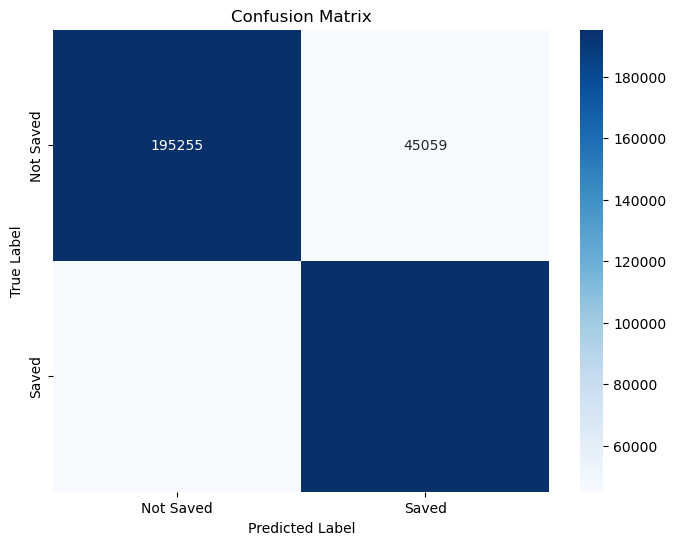

In [59]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import norm
import seaborn as sns

# build RankNet
class RankNetDataset(Dataset):
    def __init__(self, df, features, feature_importances):
        self.features = df[features].values
        self.labels = df['Saved'].values
        self.response_ids = df['ResponseID'].values
        self.feature_importances = feature_importances

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Weight the feature values ​​and use the scaled feature importance
        features = self.features[idx] * self.feature_importances
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        response_id = self.response_ids[idx]
        return features, labels, response_id

# construct a dataset and data loader with scaled feature importances
train_dataset = RankNetDataset(train_df, important_features, scaled_importances)
val_dataset = RankNetDataset(val_df, important_features, scaled_importances)
test_dataset = RankNetDataset(test_df, important_features, scaled_importances)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x

input_dim = len(important_features)
model = RankNet(input_dim)

# BCEWithLogitsLoss as loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train RankNet with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, _ in train_loader:
        features = features.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(features)  
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, _ in val_loader:
            features = features.float()
            labels = labels.float().view(-1, 1)
            outputs = model(features)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_ranknet_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_ranknet_model.pth'))

# predict and calculate confidence interval
num_bootstrap_samples = 100  # Bootstrap 
model.eval()
all_predictions = []

with torch.no_grad():
    for _ in range(num_bootstrap_samples):
        bootstrap_predictions = []
        for features, labels, response_ids in test_loader:
            features = features.float()
            outputs = torch.sigmoid(model(features)).view(-1)  # predict by sigmoid output probability
            bootstrap_predictions.extend(outputs.numpy())
        all_predictions.append(bootstrap_predictions)

all_predictions = np.array(all_predictions)  
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)

z_score = norm.ppf(0.975)  # 95% interval
lower_bounds = mean_predictions - z_score * std_predictions
upper_bounds = mean_predictions + z_score * std_predictions

predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float()
        outputs = torch.sigmoid(model(features)).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(mean_predictions[i])
            lower_bound = float(lower_bounds[i])
            upper_bound = float(upper_bounds[i])
            predictions.append((response_ids[i], mean_pred, lower_bound, upper_bound, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Probability', 'Lower CI', 'Upper CI', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Probability', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Probability'])

print(f"\n Male: \nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nMale Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Step 5 - Oversampling

In [1]:
import pandas as pd
import numpy as np
df=pd.read_csv('1116-join gender final.csv')

# create a dataframe with gender balanced
male_df = df[df['Review_gender'] == 'male']
female_df = df[df['Review_gender'] == 'female']

target_count = len(male_df)
current_female_count = len(female_df)
additional_samples_count = target_count - current_female_count

if additional_samples_count > 0:
    additional_samples = female_df.sample(n=additional_samples_count, replace=True, random_state=42)
    balanced_female_df = pd.concat([female_df, additional_samples])
else:
    balanced_female_df = female_df

balanced_df = pd.concat([male_df, balanced_female_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Number of male samples:", len(balanced_df[balanced_df['Review_gender'] == 'male']))
print("Number of female samples:", len(balanced_df[balanced_df['Review_gender'] == 'female']))
print("Total samples:", len(balanced_df))


Number of male samples: 6191588
Number of female samples: 6191588
Total samples: 12383176


In [2]:
# balanced dataaset's feature importance
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

def feature_importance(df):
        X = df[['Intervention', 'Barrier', 'if_cross_by_rule',
                'if_more_people', 'if_more_male', 'if_more_vulnerable',
                'if_more_children', 'if_more_senior', 'if_more_criminal',
                'if_more_homeless', 'if_more_profession', 'if_more_large',
                'if_more_animal']]
        y = df['Saved']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Random forest model training
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # obtain feture importance
        feature_importances = rf.feature_importances_
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("Feature Importance based on RandomForest:")
        print(feature_importance_df)


        # Permutation Importance for feature importance verification
        perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        perm_importance_df = pd.DataFrame({'Feature': X.columns, 'Permutation Importance': perm_importance.importances_mean})
        perm_importance_df = perm_importance_df.sort_values(by='Permutation Importance', ascending=False)

        print("\nFeature Importance based on Permutation Importance:")
        print(perm_importance_df)

        feature_importance_df['Rank_RF'] = feature_importance_df['Importance'].rank(ascending=False)
        perm_importance_df['Rank_Perm'] = perm_importance_df['Permutation Importance'].rank(ascending=False)

        # overall grade by Borda Count Method
        feature_importance_df['Combined Rank Score'] = feature_importance_df['Rank_RF'] + perm_importance_df['Rank_Perm']

        # rank by overall grade
        combined_rank_df = feature_importance_df[['Feature', 'Combined Rank Score']].sort_values(by='Combined Rank Score')

        print("\nCombined Feature Importance Based on Rank (Borda Count Method):")
        print(combined_rank_df)

        # plot
        plt.figure(figsize=(10, 6))
        plt.barh(combined_rank_df['Feature'], -combined_rank_df['Combined Rank Score'], color='lightblue')
        plt.xlabel('Combined Rank Score (Lower is Better)')
        plt.title('Oversampling: Combined Feature Importance Based on Rank (Borda Count Method)')
        plt.gca().invert_yaxis()
        plt.show()
feature_importance(balanced_df)

# memory is not enough to support permutation-based ranking

Feature Importance based on RandomForest:
               Feature  Importance
6     if_more_children    0.202617
2     if_cross_by_rule    0.181955
3       if_more_people    0.151481
10  if_more_profession    0.129880
12      if_more_animal    0.077283
5   if_more_vulnerable    0.063584
7       if_more_senior    0.047331
4         if_more_male    0.042070
11       if_more_large    0.026340
1              Barrier    0.022841
0         Intervention    0.022839
9     if_more_homeless    0.018110
8     if_more_criminal    0.013668


PicklingError: Could not pickle the task to send it to the workers.

In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
df = balanced_df
important_features = ['if_more_people', 'if_more_children', 'if_cross_by_rule', 'if_more_animal', 'if_more_profession', 
                'if_more_male', 'if_more_vulnerable', 'if_more_senior',  'if_more_large', 
                'if_more_homeless', 'Barrier', 'Intervention', 'if_more_criminal']

X = df[important_features]
y = df['Saved']
response_ids = df['ResponseID']

# A faster splitting method uses GroupShuffleSplit to ensure that samples with the same ResponseID are assigned to the same dataset
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=response_ids))

train_val_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

# split val&test
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(gss_val.split(train_val_df[important_features], train_val_df['Saved'], groups=train_val_df['ResponseID']))

train_df = train_val_df.iloc[train_idx]
val_df = train_val_df.iloc[val_idx]

X_train = train_df[important_features]
y_train = train_df['Saved']
X_val = val_df[important_features]
y_val = val_df['Saved']
X_test = test_df[important_features]
y_test = test_df['Saved']

Feature Importance based on RandomForest:
               Feature  Importance
6     if_more_children    0.202617
2     if_cross_by_rule    0.181955
3       if_more_people    0.151481
10  if_more_profession    0.129880
12      if_more_animal    0.077283
5   if_more_vulnerable    0.063584
7       if_more_senior    0.047331
4         if_more_male    0.042070
11       if_more_large    0.026340
1              Barrier    0.022841
0         Intervention    0.022839
9     if_more_homeless    0.018110
8     if_more_criminal    0.013668

In [6]:
# rankdom forest's original feature importance
feature_importances = [0.151481, 0.202617, 0.181955, 0.077283, 0.129880, 0.042070, 0.063584,
                       0.047331, 0.026340, 0.018110, 0.022841, 0.022839, 0.013668]

# scale to 1-10
min_importance = min(feature_importances)
max_importance = max(feature_importances)
scaled_importances = [1 + 9 * (fi - min_importance) / (max_importance - min_importance) for fi in feature_importances]

print(scaled_importances)


[7.564295127256563, 10.0, 9.015829668323201, 4.030103361224458, 6.535398440849119, 2.352841242875062, 3.3775939539240754, 2.6034326723084007, 1.6035914453106395, 1.211580902783291, 1.4369274248606767, 1.4368321610593335, 1.0]


Epoch 1/50, Loss: 0.5526857006801311
Validation Loss: 0.5443662120587222
Epoch 2/50, Loss: 0.5514916610620447
Validation Loss: 0.5429115400031234
Epoch 3/50, Loss: 0.5514702666746104
Validation Loss: 0.5461208426528678
Epoch 4/50, Loss: 0.551537120997732
Validation Loss: 0.5430003619059223
Epoch 5/50, Loss: 0.551496032479951
Validation Loss: 0.5433113318335067
Epoch 6/50, Loss: 0.5514213954336113
Validation Loss: 0.5434071124919204
Epoch 7/50, Loss: 0.5514362616073609
Validation Loss: 0.5428389442072932
Epoch 8/50, Loss: 0.5515101269954487
Validation Loss: 0.5438705191415808
Epoch 9/50, Loss: 0.5515525255515609
Validation Loss: 0.5433013355009776
Epoch 10/50, Loss: 0.551517089972088
Validation Loss: 0.5421194832380831
Epoch 11/50, Loss: 0.551488992360256
Validation Loss: 0.5426115773962464
Epoch 12/50, Loss: 0.5515378955196458
Validation Loss: 0.5428380716819563
Epoch 13/50, Loss: 0.5515295367246349
Validation Loss: 0.5426225537745363
Epoch 14/50, Loss: 0.5515216970333263
Validation Lo

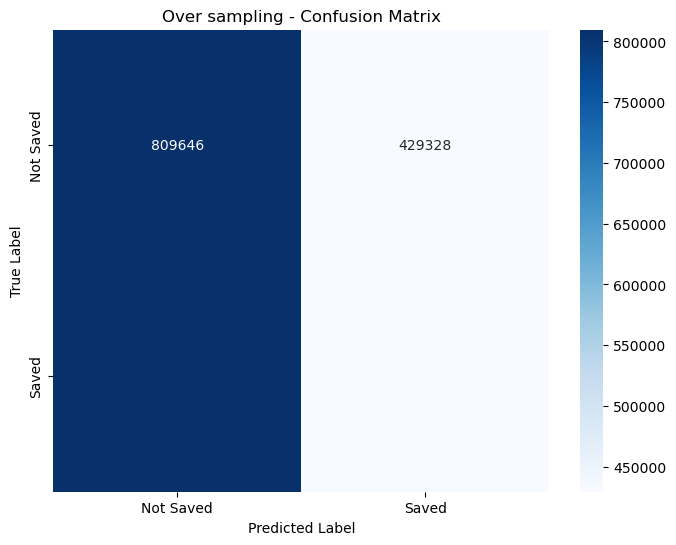

In [7]:
import torch.nn.functional as F
import numpy as np
from scipy.stats import norm
import seaborn as sns

# build RankNet
class RankNetDataset(Dataset):
    def __init__(self, df, features, feature_importances):
        self.features = df[features].values
        self.labels = df['Saved'].values
        self.response_ids = df['ResponseID'].values
        self.feature_importances = feature_importances

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Weight the feature values ​​and use the scaled feature importance
        features = self.features[idx] * self.feature_importances
        features = torch.tensor(features, dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        response_id = self.response_ids[idx]
        return features, labels, response_id

# construct a dataset and data loader with scaled feature importances
train_dataset = RankNetDataset(train_df, important_features, scaled_importances)
val_dataset = RankNetDataset(val_df, important_features, scaled_importances)
test_dataset = RankNetDataset(test_df, important_features, scaled_importances)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class RankNet(nn.Module):
    def __init__(self, input_dim):
        super(RankNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  
        return x

input_dim = len(important_features)
model = RankNet(input_dim)

# BCEWithLogitsLoss as loss function
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Train RankNet with Early Stopping
epochs = 50  
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for features, labels, _ in train_loader:
        features = features.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs = model(features)  
        loss = criterion(outputs, labels)  
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # evaluate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for features, labels, _ in val_loader:
            features = features.float()
            labels = labels.float().view(-1, 1)
            outputs = model(features)  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_ranknet_model.pth')  # keep the best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load the best model
model.load_state_dict(torch.load('best_ranknet_model.pth'))

# predict and calculate confidence interval
num_bootstrap_samples = 100  # Bootstrap 
model.eval()
all_predictions = []

with torch.no_grad():
    for _ in range(num_bootstrap_samples):
        bootstrap_predictions = []
        for features, labels, response_ids in test_loader:
            features = features.float()
            outputs = torch.sigmoid(model(features)).view(-1)  # predict by sigmoid output probability
            bootstrap_predictions.extend(outputs.numpy())
        all_predictions.append(bootstrap_predictions)

all_predictions = np.array(all_predictions)  
mean_predictions = np.mean(all_predictions, axis=0)
std_predictions = np.std(all_predictions, axis=0)

z_score = norm.ppf(0.975)  # 95% interval
lower_bounds = mean_predictions - z_score * std_predictions
upper_bounds = mean_predictions + z_score * std_predictions

predictions = []
with torch.no_grad():
    for features, labels, response_ids in test_loader:
        features = features.float()
        outputs = torch.sigmoid(model(features)).view(-1)  
        for i in range(len(response_ids)):
            mean_pred = float(mean_predictions[i])
            lower_bound = float(lower_bounds[i])
            upper_bound = float(upper_bounds[i])
            predictions.append((response_ids[i], mean_pred, lower_bound, upper_bound, float(labels[i])))

# group and sort the predictions by ResponseID
predictions_df = pd.DataFrame(predictions, columns=['ResponseID', 'Predicted Probability', 'Lower CI', 'Upper CI', 'True Label'])
response_groups = predictions_df.groupby('ResponseID')

final_predictions = []
for response_id, group in response_groups:
    group = group.sort_values(by='Predicted Probability', ascending=False)
    group['Predicted Saved'] = [1 if i == 0 else 0 for i in range(len(group))]  # the highest probability of saving is 1, and the rest are 0
    final_predictions.append(group)

final_predictions_df = pd.concat(final_predictions)

print(final_predictions_df)

# calcualte evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

y_true = final_predictions_df['True Label']
y_pred = final_predictions_df['Predicted Saved']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, final_predictions_df['Predicted Probability'])

print(f"\n Oversampling: \nModel Performance Metrics:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}")

# confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("\nOversampling Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Saved', 'Saved'], yticklabels=['Not Saved', 'Saved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Over sampling - Confusion Matrix')
plt.show()